#### Imports

In [89]:
import sys
import tweepy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
# import os.path
import nltk
import pycountry
import re
import string
import time
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from langdetect import detect
from nltk.stem import SnowballStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer

import warnings
warnings.filterwarnings('ignore')

# nltk.download('vader_lexicon')

times1 = ['2022-09-{:s}T00:00:00-05:00'.format(str(x)) for x in range(10,31)]
times2 = ['2022-10-0{:s}T00:00:00-05:00'.format(str(x)) for x in range(1,10)]
times2.append('2022-10-10T00:00:00-05:00')
times1.extend(times2) # times1: 20220910 to 20221009, 1 month

#### Authentication

In [3]:
# Authentication, Academic Research Access
bearerToken = 'AAAAAAAAAAAAAAAAAAAAAD%2BThwEAAAAAKsTwEyro7ALF12T6g5W24jvmRoc%3DZfGrc1ZS9esED0yrFHmB5whz2dI8pEeqeBr9SDkk98z6DlBu2J'
client = tweepy.Client(bearerToken)

#### Keyword and Query

In [9]:
keywords = dict()
keywords['Fetterman'] = '(Fetterman OR (John Fetterman) OR JohnFetterman OR Johnfetterman OR johnfetterman) -Oz'
keywords['Oz'] = '((Dr. Oz) OR (Dr Oz) OR (Mahmet Oz) OR (Dr. Mehmet Oz)) - Fetterman - fetterman'
# query = f'{keyword} -is:retweet lang:en'

#### Paginator: Getting tweets

In [14]:
# getting twitter for candidates
def getting_tweets(name):
    keyword = keywords[name]
    query = f'{keyword} -is:retweet lang:en'
    for i in range(len(times1)-1):
        start = times1[i]
        end = times1[i+1]
        pag = tweepy.Paginator(client.search_all_tweets,
                           query=query,
                           start_time =start,
                           end_time = end,
                           tweet_fields=['id','text', 'created_at'],
                           max_results=500)

        paginator_test = []
        for tweet in pag.flatten():
            paginator_test.append(tweet)
            time.sleep(.1)

        pd.DataFrame(paginator_test).to_csv("data/{:s}/{:s}_tweets_{:s}.csv".format(name,name, start[:10]))

# getting_tweets("Fetterman")
# getting_tweets("Oz")

#### Analysis

In [15]:
# data parsing 

def cleanUpTweet(txt):
    # Remove mentions
    txt = re.sub(r'@[A-Za-z0-9_]+', '', txt)
    # Remove hashtags
    txt = re.sub(r'#[A-Z0-9]+', '', txt)
    # Remove retweets:
    txt = re.sub(r'RT : ', '', txt)
    # Remove urls
    txt = re.sub(r'https?:\/\/[A-Za-z0-9\.\/]+', '', txt)
    #remove amp
    txt = re.sub(r'&amp;', '', txt)
    #rempve strange characters
    txt = re.sub(r'ðŸ™', '', txt)
    #remove new lines
    txt = re.sub(r'\n', ' ', txt)
    return txt


def sentiment_analysis(name): 
    for date in dates[:-1]:

        tweet_df = pd.read_csv(f"data/{name}/{name}_tweets_{date}.csv",index_col = 0)
        tweet_df['text'] = tweet_df['text'].astype(str)
        tweet_df['text'] = tweet_df['text'].apply(cleanUpTweet)
        
        # get sentiment score for each tweet
        score_lst = {}
        for i in tweet_df.index: 
            text = tweet_df.loc[i,'text']
            analysis = TextBlob(text)
            score = SentimentIntensityAnalyzer().polarity_scores(text)
            polarity = analysis.sentiment.polarity

            score_lst[i] = score
            score_lst[i]['polarity'] = polarity
        
        # store sentiment score
        kk = pd.DataFrame.from_dict(score_lst).T
        kk['text'] = tweet_df['text']
        
        # daily aggregate
        kk['pos_flag'] = kk['pos'] > kk['neg']
        kk['neg_flag'] = kk['neg'] > kk['pos']
        
        kk.to_csv(f'data/{name}/parsed_updated/{name}_{date}_parsed.csv')

In [16]:
sentiment_analysis("Fetterman")
sentiment_analysis("Oz")

#### daily aggregate

In [18]:
dates = [x[:10] for x in times1]

In [28]:
df_score = pd.DataFrame(columns = ['name','date','pos_count','pos_avg','neg_count','neg_avg','polarity'])
for name in ['Fetterman','Oz']:
    for date in dates[:-1]:
        df = pd.read_csv(f'data/{name}/parsed_updated/{name}_{date}_parsed.csv',index_col= 0)
        score_pos_count = df['pos_flag'].sum()/len(df)
        score_pos_avg = df['pos'].mean()
        score_neg_count = df['neg_flag'].sum() / len(df)
        score_neg_avg = df['neg'].sum() / len(df)
        polarity = df['polarity'].mean()
        compound = df['compound'].mean()
        
        ser = pd.Series({'name':name,'date':date, 'pos_count':score_pos_count,'pos_avg':score_pos_avg,
                                 'neg_count':score_neg_count, 'neg_avg':score_neg_avg,'polarity':polarity,'compound':compound})
        df_score = df_score.append(ser,ignore_index = True)
#         df_score = pd.concat([df_score,ser],ignore_index = True)

#### Plot

In [33]:
poll_data = pd.read_csv('data/poll_data.csv',index_col = 0)
poll_data.head()

,Date,Fetterman,Oz
0,2022-09-10,48.3,44.0
1,2022-09-11,48.3,44.0
2,2022-09-12,48.3,44.0
3,2022-09-13,48.3,44.0
4,2022-09-14,49.3,44.8


In [41]:
Fetterman = poll_data.loc[:,['Date','Fetterman']]
Fetterman['name']='Fetterman'
Fetterman.columns = ['date','poll','name']



Oz = poll_data.loc[:,['Date','Oz']]
Oz['name']='Oz'
Oz.columns = ['date','poll','name']


poll_data = pd.concat([Fetterman,Oz],ignore_index = True)

In [64]:
def plot_poll_w_sentiment(sent_measure):
    fig,ax = plt.subplots(figsize = (10,5))
    sns.lineplot(data = poll_data, x = 'date', y ='poll',hue= 'name',ax = ax )
    ax2 = plt.twinx()
    sns.lineplot(data=df_score,x = 'date', y = sent_measure,hue = 'name',ax=ax2,alpha = 0.5,linestyle = '--')
    plt.title(sent_measure,fontsize = 15)
    start, end = ax.get_xlim()
    ax.xaxis.set_ticks(np.arange(start, end, 5))
    plt.savefig(sent_measure + '.png')
    plt.show()


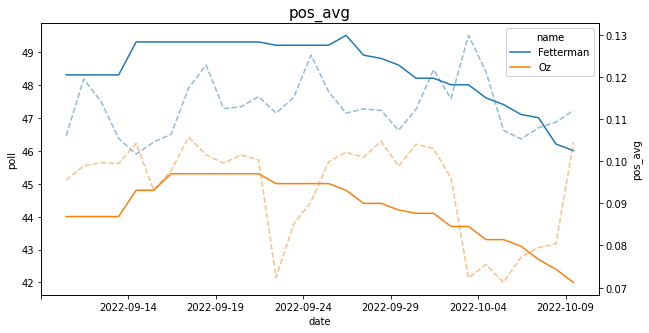

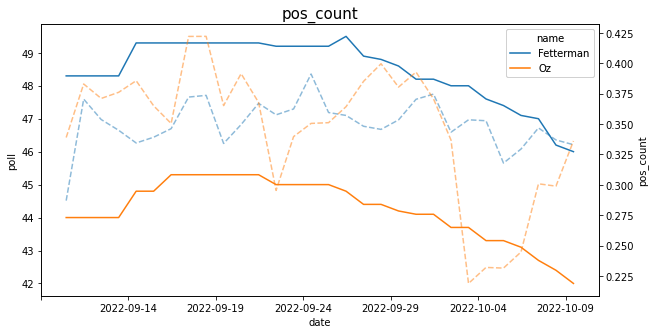

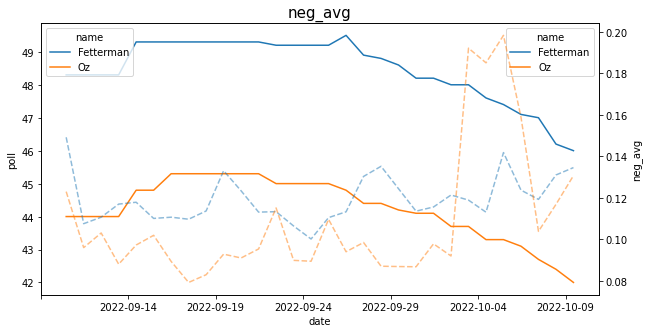

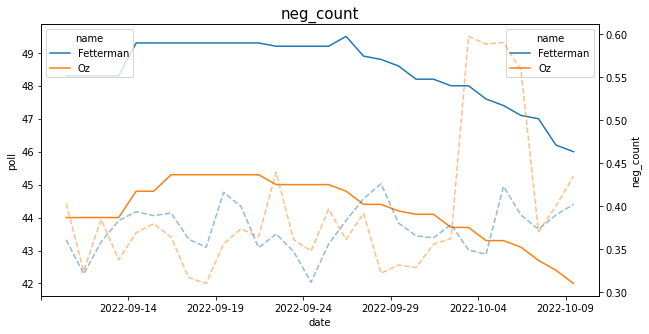

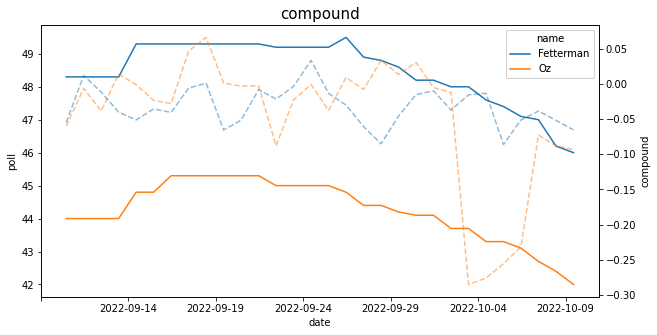

In [65]:
for m in ['pos_avg','pos_count','neg_avg','neg_count','compound']:
    plot_poll_w_sentiment(m)

## Hashtag analysis

In [81]:
name = 'Oz'
date = '2022-10-04'
tweet_df = pd.read_csv(f"data/{name}/{name}_tweets_{date}.csv",index_col = 0)

In [82]:
def find_hashtags(tweet):
    #This function extracts hashtags from the tweets.
    return re.findall('(#[A-Za-z]+[A-Za-z0-9-_]+)', tweet)
  
tweet_df['hashtags'] = tweet_df.text.apply(find_hashtags)
hashtag_list = tweet_df['hashtags'].to_list()
flat_hashtags_df = pd.DataFrame([item for sublist in hashtag_list for item in sublist])
flat_hashtags_df.shape
#change the name of the column to hashtags
flat_hashtags_df.columns = ['hashtags']
flat_hashtags_df.head()

,hashtags
0,#OzIsAPuppyTorturer
1,#DrOz329Puppies
2,#oZ
3,#DemocratsAreTheProblem
4,#RealDoctorsAgainstOz


In [113]:
pd.DataFrame(df).reset_index()

,index,hashtags
0,#DrOz,46
1,#VoteFetterman,33
2,#Pennsylvania,32
3,#PuppyKillerOz,21
4,#TurkishSpy,20
5,#FettermanIsTheBetterman,17
6,#OzIsAMonster,14
7,#FettermanForSenate,13
8,#SmartNews,13
9,#VoteBlueForSoManyReasons,12


Total hashtags:  956
Repeated hashtags:  503


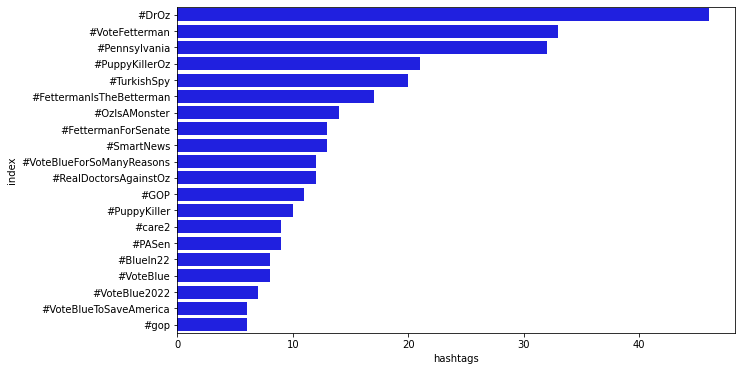

In [116]:
print("Total hashtags: ", len(flat_hashtags_df['hashtags']))
print("Repeated hashtags: ", len(flat_hashtags_df['hashtags'].unique()))

fig,ax = plt.subplots(figsize = (10,6))
df = flat_hashtags_df['hashtags'].value_counts()[:20]
df = pd.DataFrame(df).reset_index()

sns.barplot(x="hashtags", y="index", data=df,
            label="hashtag counts", color = 'b')

plt.savefig("plots/hashtagoz1004.png")


The news of dog experiment went out around Oct 3rd.

### Wordcloud

In [101]:
#Function to Create Wordcloud
def create_wordcloud(name, date):
#     mask = np.array(Image.open("cloud.png"))
    stopwords = set(STOPWORDS)
    wc = WordCloud(background_color="white",
#     mask = mask,
    max_words=300,
    width = 800,
    height = 400,
    stopwords=stopwords,
    repeat=True)
    
    df = pd.read_csv(f"data/{name}/{name}_tweets_{date}.csv",index_col = 0)
    text = df['text']
    wc.generate(str(text))
    wc.to_file(f"plots/wc_{name}_{date}.png")
    
    print("Word Cloud Saved Successfully")
    path=f"plots/wc_{name}_{date}.png"
    display(Image.open(path))

Word Cloud Saved Successfully


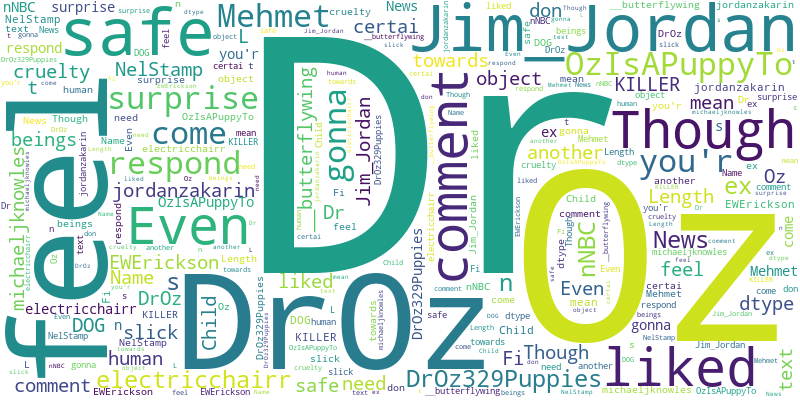

In [102]:
create_wordcloud('Oz','2022-10-04')